In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

In [4]:
from constants import *

In [5]:
import matplotlib.pyplot as plt

### Old way of pulling out corpus

In [6]:
with open(f'{CONCAT_DIR}/concat_corpus.utf') as f:
    train_contents = f.read()

In [7]:
train_contents[0:10]

'їPÿ\x07{\x919\x05)\x1c'

In [8]:
import h5py    
import numpy as np    
import json
concat_h5 = h5py.File(f'{CONCAT_DIR}/concat_corpus.h5','r+') 

concat_json = json.load(open(f'{CONCAT_DIR}/concat_corpus.json', 'rb'))

/home/paperspace/anaconda3/envs/music/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### One hot encoding

In [10]:
def one_hot(a,c): 
    return np.eye(c)[a]

In [18]:
class MusicDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, h5_file, set_type, json_file, timesteps, root_dir):
        self.concat_h5 = h5py.File(f'{root_dir}/{h5_file}','r+')
        self.dataset = self.concat_h5[set_type]
        self.concat_json = json.load(open(f'{root_dir}/{json_file}', 'rb'))
        self.vocab_size = len(self.concat_json['idx_to_token'])+1
        self.data_length = self.dataset.shape[0]
        self.timesteps = timesteps

    def __len__(self):
        return (self.data_length - self.timesteps)
#         return (self.data_length // self.timesteps)

    def __getitem__(self, idx):
#         print(np.arange(10)[0:8]) # example
#         print(np.arange(10)[8])
        # (AS) Should not have duplicate sequences. 
        # RBMs do not actually use target value, so no point in repeating next char
        x = self.dataset[idx:idx+self.timesteps]
        y = self.dataset[idx+self.timesteps]
        
#         start = idx*self.timesteps
#         x = self.dataset[start:start+self.timesteps]
#         y = self.dataset[start+self.timesteps]
#         x_hot = one_hot(x, self.vocab_size)
        return x, y


In [19]:
md = MusicDataset(h5_file='concat_corpus.h5', set_type='train', json_file='concat_corpus.json', timesteps=20, root_dir=CONCAT_DIR)

In [59]:
md.__len__()

273345

In [20]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(md,
    batch_size=batch_size)

In [21]:
SOS = 6
# SOS = location of end of time in 4/4
# '6': '\x91',
# '\x91': '|||',

### Dataset sanity test

In [22]:
train_iter = enumerate(train_loader)

In [23]:
i, (x, y) = next(train_iter)
i2, (x2, y2) = next(train_iter)

In [24]:
md.dataset[:100]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  6,  6,  6, 11,  3, 12, 13,
        6, 14,  8, 15, 16,  6, 14,  8,  4, 16,  6, 14,  8,  9, 16,  6,  2,
       17, 18, 19,  6,  7, 20, 21, 22,  6, 23, 20, 21, 22,  6, 24, 20, 21,
       22,  6, 25,  3, 26, 27,  6, 28,  8, 29, 30,  6, 23,  8, 29, 30,  6,
       24,  8, 29, 30,  6,  2, 17, 18, 31,  6,  7, 20, 21, 32,  6,  7, 20,
        4,  5,  6,  7, 20,  9, 10,  6, 23, 26, 12, 18,  6, 24, 29],
      dtype=uint8)

In [ ]:
# a = np.argmax(x[11], axis=1)[:-1]
# b = np.argmax(x[10], axis=1)[1:]
# np.testing.assert_array_equal(a, b)

In [ ]:
# a = np.argmax(x2[0], axis=1)[:-1]
# b = np.argmax(x[-1], axis=1)[1:]
# np.testing.assert_array_equal(a, b)

### Model

In [124]:
class EncoderRNN(nn.Module):
    def __init__(self, scale_size, n_factors, hidden_size, n_layers=2):
        super(EncoderRNN, self).__init__()
        self.emb = torch.nn.Embedding(scale_size, n_factors)
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(n_factors, hidden_size, batch_first=True, 
                          num_layers=n_layers)
#                           bidirectional=True)
        
    def forward(self, input, hidden):
        return self.gru(self.emb(input), hidden)

    def initHidden(self, batch_size):
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [125]:
def encode(inp, encoder):
    batch_size, input_length = inp.size()
    hidden = encoder.initHidden(batch_size).cuda()
    enc_outputs, hidden = encoder(inp, hidden)
    return long_t([SOS]*batch_size), enc_outputs, hidden

In [126]:
class DecoderRNN(nn.Module):
    def __init__(self, scale_size, n_factors, hidden_size, n_layers=2):
        super(DecoderRNN, self).__init__()
        self.emb = torch.nn.Embedding(scale_size, n_factors)
        self.gru = nn.GRU(n_factors, hidden_size, batch_first=True, num_layers=n_layers)
        self.out = nn.Linear(hidden_size, scale_size)
        
    def forward(self, inp, hidden):
        emb = self.emb(inp).unsqueeze(1)
        res, hidden = self.gru(emb, hidden)
        res = F.log_softmax(self.out(res[:,0]), dim=-1)
        return res, hidden

In [127]:
def Var(*sz): 
    if len(sz) < 2:
        t_k = torch.randn(sz)/np.sqrt(sz[0])
    else:
        t = torch.zeros(sz)
        t_k = torch.nn.init.kaiming_normal(t, a=0, mode='fan_in')
    return torch.nn.Parameter(t_k).cuda()

def Bias(*sz):
    return torch.nn.Parameter(torch.zeros(sz)).cuda()

In [135]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, scale_size, n_factors, hidden_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.emb = torch.nn.Embedding(scale_size, n_factors)
        self.W1 = Var(hidden_size, hidden_size)
        self.W2 = Var(hidden_size, hidden_size)
        self.W3 = Var(n_factors+hidden_size, hidden_size)
        self.b2 = Bias(hidden_size)
        self.b3 = Bias(hidden_size)
        self.V = Var(hidden_size)
        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=2)
        self.out = nn.Linear(hidden_size, scale_size)

    def forward(self, inp, hidden, enc_outputs):
        emb_inp = self.emb(inp)
        emb_inp = self.dropout(emb_inp)
#         print('Enc shape:', enc_outputs.shape)
#         print('W1 shape:', self.W1.shape)
# If encoder is bidirectional, we must double the outputs. See pytorch tutorial
        w1e = enc_outputs @ self.W1
        w2h = (hidden[-1] @ self.W2 + self.b2).unsqueeze(1)
        u = F.tanh(w1e + w2h)
        a = (self.V * u).sum(2)
        torch.bmm
        a = F.softmax(a, dim=-1).unsqueeze(2)
        Xa = (a * enc_outputs).sum(1)
        res = torch.cat([emb_inp, Xa.squeeze(1)], 1) @ self.W3
        res = (res + self.b3).unsqueeze(0)
        res, hidden = self.gru(res, hidden)
        res = F.log_softmax(self.out(res.squeeze(0)), dim=-1)
        return res, hidden

In [136]:
# ASHAW - deleted target size since we are only predicting 1. See original - deeplearning2 - translate-pytorch.ipynb

def train(inp, targ, encoder, decoder, enc_opt, dec_opt, crit):
    decoder_input, encoder_outputs, hidden = encode(inp, encoder)
    
    enc_opt.zero_grad(); dec_opt.zero_grad()
    loss = 0

    decoder_output, hidden = decoder(decoder_input, hidden, encoder_outputs)
#     decoder_output, hidden = decoder(decoder_input, hidden) # for normal decoder
    decoder_input = targ
    loss += crit(decoder_output, decoder_input)
    
    loss.backward()
    enc_opt.step(); dec_opt.step()
    return loss.data[0]

In [137]:
def req_grad_params(o):
    return (p for p in o.parameters() if p.requires_grad)

In [138]:
def long_t(arr): return Variable(torch.LongTensor(arr)).cuda()

In [139]:
def trainEpochs(encoder, decoder, n_epochs, print_every=10000, lr=0.001):
    loss_total = 0 # Reset every print_every
    
    enc_opt = optim.RMSprop(req_grad_params(encoder), lr=lr)
    dec_opt = optim.RMSprop(decoder.parameters(), lr=lr)
    crit = nn.NLLLoss().cuda()
    
    for epoch in range(n_epochs):
        epoch_loss = []
        for i, (data,target) in enumerate(train_loader):
            inp = torch.autograd.Variable(data.long().cuda())
            targ = torch.autograd.Variable(target.long().cuda())
            
            loss = train(inp, targ, encoder, decoder, enc_opt, dec_opt, crit)
            loss_total += loss
            epoch_loss.append(loss)
            
            if i % print_every == print_every-1:
                print(f'Iteration {i+1}. Loss: {loss_total / print_every}')
                loss_total = 0

        print(f'Epoch {epoch}. Loss:', np.mean(epoch_loss))

In [140]:
hidden_size = 128
encoder = EncoderRNN(md.vocab_size, n_factors=12, hidden_size=hidden_size).cuda()
decoder = AttnDecoderRNN(md.vocab_size, n_factors=12, hidden_size=hidden_size).cuda()
# decoder = AttnDecoderRNN_P(en_emb_t, hidden_size).cuda()

In [153]:
trainEpochs(encoder, decoder, 5, print_every=300, lr=0.005)

iteration 300 loss: 0.8163380514085293
iteration 600 loss: 0.7554223091651996
iteration 900 loss: 0.7045671861618757
iteration 1200 loss: 0.8490692144632339
iteration 1500 loss: 0.7600323867797851
iteration 1800 loss: 0.8027548969785372
iteration 2100 loss: 0.6801020619273186
iteration 2400 loss: 0.766221761306127
iteration 2700 loss: 0.7849357808132966
iteration 3000 loss: 0.7168189486612876
iteration 3300 loss: 0.7011970803141594
iteration 3600 loss: 0.8384964121381442
iteration 3900 loss: 0.7792342467109362
iteration 4200 loss: 0.8187494166692098
Epoch 0 loss: 0.7681482396165279
iteration 300 loss: 0.8528565761446952
iteration 600 loss: 0.7590376927951972
iteration 900 loss: 0.7186621319254239
iteration 1200 loss: 0.8776449112097422
iteration 1500 loss: 0.7792076162497202
iteration 1800 loss: 0.7977067322532336
iteration 2100 loss: 0.679408333748579
iteration 2400 loss: 0.7737932443618775
iteration 2700 loss: 0.8087839002907277
iteration 3000 loss: 0.7427827994773786
iteration 3300 

KeyboardInterrupt: 

### Testing encoder-decoder

In [175]:
def evaluate(inp):
    inp = torch.autograd.Variable(torch.Tensor(inp.reshape(1, -1))).long().cuda()
    decoder_input, encoder_outputs, hidden = encode(inp, encoder)
    target_length = maxlen

    decoded_words = []
    for di in range(target_length):
#         decoder_output, hidden = decoder(decoder_input, hidden)
        decoder_output, hidden = decoder(decoder_input, hidden, encoder_outputs)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        decoded_words.append(ni)
        decoder_input = long_t([ni])
    
    return decoded_words

### Generate music

Need to change sequence_length to timesteps  
Need to have unknown state 0?

In [176]:
import decode

In [177]:
def decode_output(output_idx):
    idx2token = md.concat_json['idx_to_token']
    token_list = list(map(lambda x: idx2token.get(str(x), ''), output_idx))
    return decode_token(token_list)

def decode_token(token_list):
    if (token_list[0] != START_DELIM):
        token_list.insert(0, START_DELIM)
    token_str = ''.join(token_list)
    with open(f'{SCRATCH_DIR}/utf_to_txt.json', 'r') as f:
        utf_to_txt = json.load(f)
    score, stream = decode.decode_string(utf_to_txt, token_str)
    return token_str, score, stream

# test = [idx2token[f'{x}'] for x in seq_arr]; test

In [178]:
maxlen = 200

In [179]:
gen_song = md.dataset[:md.timesteps]
decoded_words = evaluate(gen_song)
output_song = gen_song.tolist() + decoded_words

In [180]:
token_str, score, stream = decode_output(decoded_words)

In [181]:
token_str

'їÐÐÐÐÐÐÐÐÐÐÐÐææææÐÐæÐæÐÐÐ\x91Ð\x91Ð\x91Ð\x91Ð\x91Ð\x91ÐÐæÐÐ\x91\x91\x91\x91\x91\x91ææÐæææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææ'

### For testing stuff

In [ ]:
with open(f'{SCRATCH_DIR}/utf_to_txt.json', 'r') as f:
    utf_to_txt = json.load(f)

In [ ]:
test_str = train_contents[:200]

In [ ]:
test_str = open(f'{SCRATCH_DIR}/BWV-400-nomask-fermatas.utf', 'r').read()[:200]

In [ ]:
token_str, score, stream = decode_token(test_str)

In [ ]:
stream.elements[:10]

### Evaluate stream

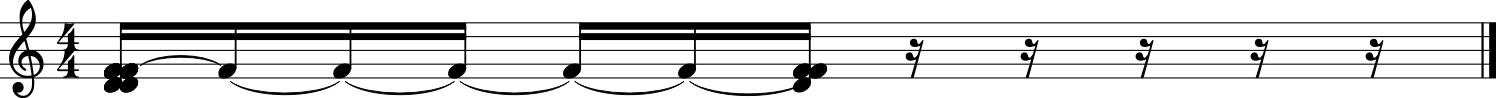

In [182]:
stream.show()

In [ ]:
fp = stream.write('midi', fp=f'{OUT_DIR}/testout.midi')

In [152]:
fp = stream.write('xml', fp=f'{OUT_DIR}/testout.xml')

In [ ]:
from IPython.lib.display import FileLink
FileLink('../data/bachbot/out/testout.midi')